<a href="https://colab.research.google.com/github/IAmSuyogJadhav/3DUnet-Tensorflow-Brats18/blob/master/Step_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep  7 17:05:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Colab Stuff

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!7z x '/gdrive/My Drive/Step-Counting/PedometerDataset-cleaned.zip'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /gdrive/My Drive/Step-Counting/                                         1 file, 192198211 bytes (184 MiB)

Extracting archive: /gdrive/My Drive/Step-Counting/PedometerDataset-cleaned.zip
--
Path = /gdrive/My Drive/Step-Counting/PedometerDataset-cleaned.zip
Type = zip
Physical Size = 192198211

  0%      2% 15 - data/P016/Regular/Hip.csv                                     4% 28 - data/P015/SemiRegular/Hip.csv                                         7% 43 - data/P024/Unstructured/Wrist.csv


# Imports

In [1]:
# For better CUDA-related errors
%env CUDA_LAUNCH_BLOCKING=1

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import torch 
from torch import nn
from torchsummary import summary
from sklearn.metrics import f1_score
from collections.abc import Iterable
import shutil

env: CUDA_LAUNCH_BLOCKING=1


# Loading Data

In [0]:
def read_data_folder(folder, to_read='Wrist'):
    """
    read_data_folder(folder, to_read='Wrist')
    -----------------
    Designed to work on Pedometer Evaluation Project Dataset.
    Reads the data and corresponding labels from a single subfolder of the
    dataset.

    Parameters
    ----------
    `folder`: string, required
        The folder having at least these two files: {to_read}.csv and
        steps.txt.
    `to_read`: string, optional
        Indicates which data is to be read. Defaults to "Wrist". Can be one of
        ['Wrist', 'Hip', 'Ankle']

    Returns
    -------
    `data`: pandas.DataFrame object
         The data loaded from the given subfolder, along with the labels in a
         single DataFrame object. Shape: (n, 20), n is variable.
    """

    assert to_read in ['Wrist', 'Hip', 'Ankle'], \
        "to_read must be one of ['Wrist', 'Hip', 'Ankle']"
    data = pd.read_csv(
        os.path.join(folder, f'{to_read}.csv'), skiprows=[0, 2], delimiter='\t'
        )
    data['gap'] = 0
    data['gap'][1:] = (
        data.Timestamp.values[1:] - data.Timestamp.values[:-1]
        ).astype(np.int)

    # Read the labels file
    label = pd.read_csv(
        os.path.join(folder, 'steps.txt'),
        delim_whitespace=True, names=['t', 'move']
        )
    
    # Ignoring shifts for now.
    mask = label.t[label.move.str[1:] != 'shift']

    # Convert the labels to one-hot format and add to the data
    data['label'] = np.zeros(len(data), dtype=int)
    data['label'][mask] = 1

    # Check for large gaps and ignore all the values after them.
    if len(data.index[data.gap > 133]):
        data.drop(
            range(data.index[data.gap > 133][0], len(data)),
            axis=0, inplace=True
            )
    return data


def read_data(data_path, to_read='Wrist'):
    """
    read_data(folder, to_read='Wrist')
    -----------------
    Designed to work on Pedometer Evaluation Project Dataset.
    Reads the data and corresponding labels from a all the subfolders of the
    dataset.

    Parameters
    ----------
    `folder`: string, required
        The folder containing the data folders, each of which contains 3
         subfolders: Regular, SemiRegular and Unstructured, each having at
          least these two files: {to_read}.csv and steps.txt.
    `to_read`: string, optional
        Indicates which data is to be read. Defaults to "Wrist". Can be one of
        ['Wrist', 'Hip', 'Ankle']

    Returns
    -------
    `data`: list
        A list of pandas.DataFrame objects generated by reading all the
        training examples (and their labels) in the dataset.
    """

    assert to_read in ['Wrist', 'Hip', 'Ankle'], \
        "to_read must be one of ['Wrist', 'Hip', 'Ankle']"

    data = []

    # Gather a list of all the subfolders
    subfolders = [f[1] for f in os.walk(data_path)][0]

    # Just needed for the progress bar
    total = len(subfolders)
    step = 25 / total
    for i, sub in enumerate(subfolders):
        # Each subfolder has these 3 directories
        for sub2 in ['Regular', 'SemiRegular', 'Unstructured']:
            d = read_data_folder(os.path.join(data_path, sub, sub2), to_read)
            data.append(d)

        # Print the progress bar
        print(
            '\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i + 1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end=''
            )

    return data


def generate_data(
    data, window=32,
    features=[
        'QuatW', 'QuatX', 'QuatY', 'QuatZ', 'GyroX', 'GyroY', 'GyroZ',
        'AccelX', 'AccelY', 'AccelZ', 'MagX', 'MagY', 'MagZ'
            ]):
    """
    generate_data(data, window=32, features=['QuatW', QuatX...)
    -----------------------------------------------------------
    Designed to work on Pedometer Evaluation Project Dataset.
    Takes as input the data loaded from the dataset using the `read_data`
    function and gives as output the numpy array generated by reading only the
    selected features from the dataset and using specified window size.

    Parameters
    ----------
    `data`: list, required
        A list of pandas.DataFrame objects generated by calling the `read_data`
        function on the dataset.
    `window`: int, optional
        No. of readings to put in a single training example. Defaults to 32.
    `features`: list, optional
        List of features from the training data to be used. Defaults to all of
        them being used (['QuatW', 'QuatX', 'QuatY', 'QuatZ', 'GyroX', 'GyroY',
        'GyroZ', 'AccelX', 'AccelY', 'AccelZ', 'MagX', 'MagY', 'MagZ]).

    Returns
    -------
    `dat`: numpy.array object
        All the data loaded according to given specifications, in a single
        numpy array. Shape: (n, window, n_f), n is the total no. of windows
        that could be generated, n_f is the length of `features` list.
    `lbl`: numpy.array object
        One-hot encoded labels corresponding to the data. Shape: (n, window),
        n is the total no. of windows that could be generated.
    """
    dat = []  # To store the data
    lbl = []  # To store the labels

    # For progress bar
    total = len(data)
    step = 25 / total
    for i, df in enumerate(data):
        for j in range(len(df) // window):

            # 1 is subtracted from the end index, because pandas loc includes
            # the end index while slicing
            dat.append(
                df.loc[j * window: (j + 1) * window - 1, features].values)
            lbl.append(
                df.loc[j * window: (j + 1) * window - 1, 'label'].values)

        # Print Progress Bar
        print(
            '\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')

    dat = np.array(dat)
    lbl = np.array(lbl)
    return dat, lbl

In [3]:
#@title Set options
window = 76 #@param

features = [
    'QuatW', 'QuatX', 'QuatY', 'QuatZ',
    'GyroX', 'GyroY', 'GyroZ',
    # 'AccelX', 'AccelY', 'AccelZ',
    'MagX', 'MagY', 'MagZ'
        ]
input_size = len(features)
print("Reading Data...\n")
data = read_data('/content/data/')
print('\nDone!\n')
print(f"Generating Data with window size of {window}...\n")
X, y = generate_data(data, window=window, features=features)
print('\nDone!\n')
print('*'*20)
print(f'Data shape: {X.shape}')

Reading Data...



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Progress: [=========================](100 %)
Done!

Generating Data with window size of 76...

Progress: [=========================](100 %)
Done!

********************
Data shape: (12482, 76, 10)


In [4]:
split = 0.8
n = len(X)

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


X_train = X[:int(split * n), ...].astype(np.float32)
y_train = y[:int(split * n), ...].astype(np.float32)
X_val = X[int(split * n):, ...].astype(np.float32)
y_val = y[int(split * n):, ...].astype(np.float32)

y_train = torch.from_numpy(y_train).to(device)
X_train = torch.from_numpy(X_train).to(device)
y_val = torch.from_numpy(y_val).to(device)
X_val = torch.from_numpy(X_val).to(device)

GPU is available


In [0]:
# # Testing
# X_bak = X.copy()
# y_bak = y.copy()

# Helper Functions

In [0]:
# def pretty_size(size):
# 	"""Pretty prints a torch.Size object"""
# 	assert(isinstance(size, torch.Size))
# 	return " × ".join(map(str, size))

# def dump_tensors(gpu_only=True):
# 	"""Prints a list of the Tensors being tracked by the garbage collector."""
# 	import gc
# 	total_size = 0
# 	for obj in gc.get_objects():
# 		try:
# 			if torch.is_tensor(obj):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s:%s%s %s" % (type(obj).__name__, 
# 										  " GPU" if obj.is_cuda else "",
# 										  " pinned" if obj.is_pinned else "",
# 										  pretty_size(obj.size())))
# 					total_size += obj.numel()
# 			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
# 												   type(obj.data).__name__, 
# 												   " GPU" if obj.is_cuda else "",
# 												   " pinned" if obj.data.is_pinned else "",
# 												   " grad" if obj.requires_grad else "", 
# 												   " volatile" if obj.volatile else "",
# 												   pretty_size(obj.data.size())))
# 					total_size += obj.data.numel()
# 		except Exception as e:
# 			pass        
# 	print("Total size:", total_size)

# def pretty_size(size):
# 	"""Pretty prints a torch.Size object"""
# 	assert(isinstance(size, torch.Size))
# 	return " × ".join(map(str, size))

# def dump_tensors(gpu_only=True):
# 	"""Prints a list of the Tensors being tracked by the garbage collector."""
# 	import gc
# 	total_size = 0
# 	for obj in gc.get_objects():
# 		try:
# 			if torch.is_tensor(obj):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s:%s%s %s" % (type(obj).__name__, 
# 										  " GPU" if obj.is_cuda else "",
# 										  " pinned" if obj.is_pinned else "",
# 										  pretty_size(obj.size())))
# 					total_size += obj.numel()
# 			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
# 												   type(obj.data).__name__, 
# 												   " GPU" if obj.is_cuda else "",
# 												   " pinned" if obj.data.is_pinned else "",
# 												   " grad" if obj.requires_grad else "", 
# 												   " volatile" if obj.volatile else "",
# 												   pretty_size(obj.data.size())))
# 					total_size += obj.data.numel()
# 		except Exception as e:
# 			pass        
# 	print("Total size:", total_size)
# 
# 
# def re_init_weights(m):        
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)
# def save_checkpoint(state, is_best, filename):
#     """Save checkpoint if a new best is achieved"""
#     if is_best:
#         # print ("=> Saving a new best")
#         torch.save(state, filename)  # save checkpoint
#     else:
#         # print ("=> Validation Accuracy did not improve")
#         pass
# 
# 
def get_last_state(models_dir, model_prefix='Model'):
    r"""
    Gives out the path to the last model and its epoch number.
    Expect models to be named as (regex): {model}-.*Epoch-\d*\.h5
    where {model} is the prefix of your model checkpoints, defaults to "Model".
    """
    path = os.path.join(models_dir, f"{model_prefix}-*.")
    models = glob.glob(path)

    re_escape = ['(', ')', '.']
    for ch in re_escape:
        model_prefix = model_prefix.replace(ch, '\\' + ch)
    
    if models:
        pat = re.compile(f'.*/{model_prefix}-.*Epoch(\\d*)\\.pth')
        last_model = sorted(models, reverse=True, key=lambda m: int(pat.findall(m)[0]))[0]
        epoch = int(pat.findall(last_model)[0])
        print(f"Found last model at:{last_model}\nEpoch no.: {epoch}")
        return last_model, epoch
    else:
        print(f"No model found matching {path}")
        return None, 0


def weights_init(m):
    try:
        nn.init.xavier_uniform(m.weight.data)
        nn.init.xavier_uniform(m.bias.data)
    except AttributeError:
        print(AttributeError(m))


def weighted_binary_cross_entropy(output, target, weights=[0.94, 0.06]):
        
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))


def f1_loss(y_true, y_pred, eps=1e-10):
    
    tp = torch.sum((y_true*y_pred).to(torch.float), dim=0)
    tn = torch.sum(((1-y_true)*(1-y_pred)).to(torch.float), dim=0)
    fp = torch.sum(((1-y_true)*y_pred).to(torch.float), dim=0)
    fn = torch.sum((y_true*(1-y_pred)).to(torch.float), dim=0)

    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)

    f1 = 2 * p * r / (p + r + eps)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 1 - torch.mean(f1)


class Flatten(nn.Module):
    def forward(self, input):
        return input.contiguous().view(input.shape[0], -1)

In [0]:
class Master(nn.Module):
    def __init__(self):
        super(Master, self).__init__()
        self.model = 's'
        self.compare_fn = None
        self.epoch = None
        self.mse = nn.MSELoss()
        self.epochs_since_ckpt = 0


        # Must be defined by the child class
        self.init_args = None
        self.optimizer = None
        self.deq = None

    def checkpoint(self, monitor_value, save_name, save_best_only=True):

        # Check if we should save the checkpoint
        save_ckpt = self.compare_fn(monitor_value)

        if save_ckpt or not save_best_only:
            ckpt = {'model': self.__class__(*self.init_args),
                    'state_dict': self.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                    'epoch': self.epoch
                    }
            save_name = save_name.format(
                epoch=self.epoch,
                val_loss=self.val_loss,
                val_acc=self.val_acc,
                loss=self.loss,
                acc=self.acc)
            torch.save(ckpt, save_name)

            # Reset epochs_since_ckpt counter
            self.epochs_since_ckpt = 0

        else:
            pass


    def fit(self, X_train, y_train, X_val, y_val, epochs, lr, optimizer, criterion, save_name, monitor='val_loss', save_every=50, patience=3, save_best_only=True, regression=False):

        assert monitor in ['val_acc', 'val_loss'], 'Not a suitable choice.'
        assert os.path.exists(os.path.dirname(save_name)), "Save directory doesn't exist"

        if monitor == 'val_loss':
            self.compare_fn = lambda new: (new < np.array(self.deq)).any()
        elif monitor == 'val_acc':
            self.compare_fn = lambda new: (new > np.array(self.deq)).any()

        # Define Loss, Optimizer
        self.criterion = criterion
        self.optimizer = optimizer(self.parameters(), lr=lr)

        # Initialize the Deque for checkpointing
        self.deq = deque(maxlen=patience)

        # Training
        for epoch in range(1, epochs + 1):
            self.epoch = epoch
            self.optimizer.zero_grad()  # Clear existing gradient
            output, hidden = self.__call__(X_train)
            # print(output.shape)
            loss = self.criterion(output.contiguous().view(output.shape[0], -1), y_train.contiguous().view(y_train.shape[0], -1))
                # + self.step_loss(output.view(output.shape[0], -1), y_train)
            self.loss = loss.item()
            name, self.acc = self.accuracy(output, y_train) if not regression else self.step_loss(output, y_train)

            # Evaluate on validation
            with torch.no_grad():
                output_val, _ = self.__call__(X_val)
                self.val_loss = (self.criterion(output_val.contiguous().view(output_val.shape[0], -1), y_val.contiguous().view(y_val.shape[0], -1))).item()
                        #  + self.step_loss(output_val.view(output_val.shape[0], -1), y_val.view(y_val.shape[0], -1))).item()
                name, self.val_acc = self.accuracy(output_val, y_val) if not regression else self.step_loss(output_val, y_val)
                # self.step_loss

            # Append the metric value to queue
            self.deq.append(eval('self.' + monitor))

            # Check if it's been enough epochs since last checkpoint 
            if self.epochs_since_ckpt >= save_every:
                self.checkpoint(eval('self.' + monitor), save_name, save_best_only)
            else:
                self.epochs_since_ckpt += 1

            loss.backward()  # Does backprop and calculates grad
            self.optimizer.step()  # Update the weights

            print('\rEpoch: {}/{}.............'.format(epoch, epochs), end=' ')
            print("Loss: {:.4f} {name}: {:.4f}, Val_Loss: {:.4f} {name}: {:.4f}".format(
                self.loss, self.acc, self.val_loss, self.val_acc, name=name), end='')

    def accuracy(self, y_pred, y_true, thresh=0.5):
        """Actually calculates F1 score."""
        # print(y_pred.shape)
        # print(y_true.shape)

        y_p = y_pred.detach().cpu().clone().numpy()
        y_t = y_true.detach().cpu().clone().numpy()
        # print(type(y_p))
        return 'F1 Score', f1_score(y_t.flatten(), (y_p >= thresh).flatten())

    def step_loss(self, y_pred, y_true):
        """Calculates MSE between calculated and actual no. of steps"""
        # s_true = torch.sum(y_true, dim=1)
        # s_pred = torch.sum(y_pred.round(), dim=1)
        y_p = y_pred.detach().cpu().clone()
        y_t = y_true.detach().cpu().clone()
        return 'Step Loss', self.mse(y_p, y_t)

# Models

## Vanilla RNN

In [0]:
class Model(Master):
    def __init__(self, input_size, output_size, seq_len, hidden_dim, n_cells, n_fc, fc_act=nn.ReLU(), regression=False):
        """
        Model(input_size, output_size, hidden_dim, n_rnn, n_fc)
        -------------------------------------------------------
        <TODO>

        Parameters
        ----------
        input_size: int, required
            No. of features per timestep in the input.
        output_size: int, required
            No. of samples in the output
        hidden_dim: int, required
            No. of nodes in the hidden layer of RNN
        n_cells: int, required
            No. of consecutive RNN units to stack
        n_fc: list, required
            A list of integers with no. of nodes to add in each FC layer.

        """
        super(Model, self).__init__()

        assert isinstance(n_fc, Iterable) and len(n_fc) >= 1,\
             "Must be an iterable with length greater than or equal to 1"
        # Needed for parent class
        self.init_args = (input_size, output_size, seq_len, hidden_dim, n_cells, n_fc, fc_act, regression)
        self.deq = None
        
        self.hidden = None
        self.hidden_dim = hidden_dim
        self.n_cells = n_cells
        self.regression = regression

        # RNN Architecture
        self.rnn = nn.RNN(input_size, hidden_dim, n_cells, batch_first=True, nonlinearity='tanh')
        self.flatten = Flatten()

        # FC Layers
        self.fc = []
        last_dim = seq_len * hidden_dim
        for n_dims in n_fc:
            self.fc.append(nn.Linear(last_dim, n_dims))
            last_dim = n_dims

        self.fc = nn.ModuleList(self.fc)  # Required to run on CUDA
        self.fc_act = fc_act
        self.out_fc = nn.Linear(n_fc[-1], output_size)
        self.act = nn.functional.tanh

    def forward(self, x):
        # batch_size = x.size(0)
        # print(x.shape)
        # Initialize hidden state for first input
        # if self.hidden is None:
        #     hidden = self.init_hidden(batch_size)
        # else:
        #     hidden = self.hidden

        # Passing into RNN
        
        out, hidden = self.rnn(x)  #, self.hidden)
        out = self.flatten(out)
        # print(out.shape)
        for fc in self.fc:
            out = fc(out)
            out = self.fc_act(out)

        out = self.out_fc(out)
        if not self.regression:
            out = (self.act(out) + 1) / 2
        # self.hidden = hidden
        return out, hidden


# LSTM

In [0]:
# class Model(Master):
#     def __init__(self, input_size, output_size, hidden_dim, n_layers):
#         super(Model, self).__init__()

#         # Needed for parent class
#         self.init_args = (input_size, output_size, hidden_dim, n_layers)
#         self.deq = None
        
#         self.hidden = None
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers

#         # RNN Architecture
#         self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_size)
#         self.act = nn.functional.tanh

#     def forward(self, x):
#         # batch_size = x.size(0)
#         print(x.shape)
#         # Initialize hidden state for first input
#         # if self.hidden is None:
#         #     hidden = self.init_hidden(batch_size)
#         # else:
#         #     hidden = self.hidden

#         # Passing into RNN
        
#         out, hidden = self.lstm(x)  #, self.hidden)
#         out = self.fc(out[:, -1, :])
#         out = self.act(out)
#         # self.hidden = hidden
#         return out, hidden


class Model(Master):
    def __init__(self, input_size, output_size, seq_len, hidden_dim, n_cells, n_fc, fc_act=nn.ReLU(), regression=False):
        """
        Model(input_size, output_size, hidden_dim, n_rnn, n_fc)
        -------------------------------------------------------
        <TODO>

        Parameters
        ----------
        input_size: int, required
            No. of features per timestep in the input.
        output_size: int, required
            No. of samples in the output
        hidden_dim: int, required
            No. of nodes in the hidden layer of RNN
        n_cells: int, required
            No. of consecutive LSTM units to stack
        n_fc: list, required
            A list of integers with no. of nodes to add in each FC layer.

        """
        super(Model, self).__init__()

        assert isinstance(n_fc, Iterable) and len(n_fc) >= 1,\
             "Must be an iterable with length greater than or equal to 1"
        # Needed for parent class
        self.init_args = (input_size, output_size, seq_len, hidden_dim, n_cells, n_fc, fc_act, regression)
        self.deq = None
        
        self.hidden = None
        self.hidden_dim = hidden_dim
        self.n_cells = n_cells
        self.regression = regression

        # RNN Architecture
        self.lstm = nn.LSTM(input_size, hidden_dim, n_cells, batch_first=True) #, nonlinearity='tanh')
        self.flatten = Flatten()

        # FC Layers
        self.fc = []
        last_dim = seq_len * hidden_dim
        for n_dims in n_fc:
            self.fc.append(nn.Linear(last_dim, n_dims))
            last_dim = n_dims

        self.fc = nn.ModuleList(self.fc)  # Required to run on CUDA
        self.fc_act = fc_act
        self.out_fc = nn.Linear(n_fc[-1], output_size)
        self.act = nn.functional.tanh

    def forward(self, x):
        # batch_size = x.size(0)
        # print(x.shape)
        # Initialize hidden state for first input
        # if self.hidden is None:
        #     hidden = self.init_hidden(batch_size)
        # else:
        #     hidden = self.hidden

        # Passing into RNN
        
        out, hidden = self.lstm(x)  #, self.hidden)
        out = self.flatten(out)
        # print(out.shape)
        for fc in self.fc:
            out = fc(out)
            out = self.fc_act(out)

        out = self.out_fc(out)
        if not self.regression:
            out = (self.act(out))  # + 1) / 2
        # self.hidden = hidden

        return out, hidden


# Training

In [0]:
regression = True  #@param {type: "boolean"}
hidden_dim = 20  #@param {type: "integer"}
n_cells = 20  #@param {type: "integer"}
n_fc = [20, 30]  #@param {type:"raw"}
# fc_act = nn.functional.tanh
fc_act = torch.tanh

model = Model(
    input_size=input_size,
    output_size=window if not regression else 1,
    seq_len=window,
    hidden_dim=hidden_dim,
    n_cells=n_cells,
    n_fc=n_fc,
    fc_act = fc_act,
    regression=True
    )

model = model.to(device)
# model.apply(weights_init)
# summary(model, (window, input_size))

if not regression:
    # criterion = nn.BCELoss()
    # criterion = weighted_binary_cross_entropy
    criterion = f1_loss
else:
    criterion = nn.MSELoss()

optimizer = torch.optim.Adam

In [10]:
#@title Set training parameters
epochs = 200 #@param
lr = 1e-3 #@param
models_dir = '/gdrive/My Drive/Step-Counting/RNN/' #@param
model_name = 'Model.LSTM-regression_quat_features_only-train_acc={acc}-val_acc={val_acc}-Epoch-{epoch}.pth' #@param
save_name = os.path.join(models_dir, model_name)
if regression:
    save_name = save_name.replace('acc', 'loss')


model.fit(
    X_train, y_train if not regression else torch.sum(y_train, dim=1).view([len(y_train), 1]),
    X_val, y_val if not regression else torch.sum(y_val, dim=1).view([len(y_val), 1]),
    epochs, lr,
    optimizer,
    criterion,
    save_name=save_name,
    regression=regression,
    patience=100
    )

Epoch: 50/200............. Loss: 21.6477 Step Loss: 21.6477, Val_Loss: 21.1163 Step Loss: 21.1163

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 184/200............. Loss: 17.7936 Step Loss: 17.7936, Val_Loss: 18.0415 Step Loss: 18.0415

KeyboardInterrupt: ignored

In [17]:
print(model(X_val[0:1])[0])
print(torch.sum(y_val[0:1], dim=1))

tensor([[4.5331]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([10.], device='cuda:0')


## Fastai

In [0]:
from fastai.basic_train import Learner
from fastai.basic_data import Dataset, DataBunch

In [0]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 1 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
X_train = X[:int(split * n), ...].astype(np.float32)
y_train = y[:int(split * n), ...].astype(np.float32)
X_val = X[int(split * n):, ...].astype(np.float32)
y_val = y[int(split * n):, ...].astype(np.float32)

In [0]:
train, val = ArrayDataset(X_train, y_train), ArrayDataset(X_val, y_val)

In [0]:
data = DataBunch.create(train, val, bs=1, num_workers=1)

In [0]:
learn = Learner(data, Model, )

torch.Size([2, 76])

# Scratchpad

In [0]:
regression = True  #@param {type: "boolean"}
hidden_dim = 40  #@param {type: "integer"}
n_rnn = 20  #@param {type: "integer"}
n_fc = [40, 20, 10, 5]  #@param {type:"raw"}
# fc_act = nn.functional.tanh
fc_act = torch.tanh

model = Model(
    input_size=input_size,
    output_size=window if not regression else 1,
    hidden_dim=hidden_dim,
    n_rnn=n_rnn,
    n_fc=n_fc,
    fc_act = fc_act
    )

model = model.to(device)
# model.apply(weights_init)
summary(model, (window, input_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 76, 40], [-1, 2, 40]]               0
           Flatten-2                 [-1, 3040]               0
            Linear-3                   [-1, 40]         121,640
            Linear-4                   [-1, 20]             820
            Linear-5                   [-1, 10]             210
            Linear-6                    [-1, 5]              55
            Linear-7                    [-1, 1]               6
Total params: 122,731
Trainable params: 122,731
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.83
Params size (MB): 0.47
Estimated Total Size (MB): 2.30
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
# import pickle
loaded = torch.load('/gdrive/My Drive/Step-Counting/RNN/models/Model.RNN-regression.Epoch262-train_acc=29.385305404663086-val_acc=33.1422004699707.pth')
# model.load_state_dict()

In [0]:
model = loaded['model']
model.load_state_dict(loaded['state_dict'])
for p in model.parameters():
    p.requires_grad = False

model.eval()
model.to(device)

Model(
  (mse): MSELoss()
  (rnn): RNN(13, 40, num_layers=20, batch_first=True)
  (flatten): Flatten()
  (fc): ModuleList(
    (0): Linear(in_features=3040, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=5, bias=True)
  )
  (fc_act): ReLU()
  (out_fc): Linear(in_features=5, out_features=1, bias=True)
)

In [0]:
#@title Default title text
i = 695 #@param {type:"slider", min:0, max:1000, step:1}

print(model(X_train[i][None, ...])[0])
print(y_train[i].sum())

tensor([[1.]], device='cuda:0')
tensor(0., device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Basic RNN

In [0]:
# # text = ['hey how are you','good i am fine','have a nice day']
# chars = set(''.join(text))
# int2char = dict(enumerate(chars))
# char2int = {char: ind for ind, char in int2char.items()}


In [0]:
# # Finding the length of the longest string in our data
# maxlen = len(max(text, key=len))

# # Padding

# # A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of
# # the sentence matches the length of the longest sentence
# for i in range(len(text)):
#   while len(text[i])<maxlen:
#       text[i] += ' '

In [0]:
# # Creating lists that will hold our input and target sequences
# input_seq = []
# target_seq = []

# for i in range(len(text)):
#     # Remove last character for input sequence
#     input_seq.append(text[i][:-1])

#     # Remove first character for target sequence
#     target_seq.append(text[i][1:])
#     print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: hey how are yo
Target Sequence: ey how are you
Input Sequence: good i am fine
Target Sequence: ood i am fine 
Input Sequence: have a nice da
Target Sequence: ave a nice day


In [0]:
# for i in range(len(text)):
#     input_seq[i] = [char2int[character] for character in input_seq[i]]
#     target_seq[i] = [char2int[character] for character in target_seq[i]]

In [0]:
# dict_size = len(char2int)
# seq_len = maxlen - 1
# batch_size = len(text)

# def one_hot_encode(sequence, dict_size, seq_len, batch_size):
#     # Creating a multi-dimensional array of zeros with the desired output shape
#     features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
#     # Replacing the 0 at the relevant character index with a 1 to represent that character
#     for i in range(batch_size):
#         for u in range(seq_len):
#             features[i, u, sequence[i][u]] = 1
#     return features

In [0]:
# input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)

In [0]:
# input_seq = torch.from_numpy(input_seq)
# target_seq = torch.Tensor(target_seq)

In [0]:
# input_seq.shape

(3, 14, 17)

In [0]:
# len(target_seq[0])

14

In [0]:
# # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# is_cuda = torch.cuda.is_available()

# # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
# if is_cuda:
#     device = torch.device("cuda")
#     print("GPU is available")
# else:
#     device = torch.device("cpu")
#     print("GPU not available, CPU used")

GPU is available


In [0]:
# class Model(nn.Module):
#     def __init__(self, input_size, output_size, hidden_dim, n_layers):
#         super(Model, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.n_layers = n_layers

#         # RNN Architecture
#         self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_size)

#     def forward(self, x):
#         batch_size = x.size(0)

#         # Initialize hiddedn state for first input
#         hidden = self.init_hidden(batch_size)

#         # Passing into RNN
#         out, hidden = self.rnn(x, hidden)
        
#         # Reshape and pass on to FC layer
#         out = out.contiguous().view(-1, self.hidden_dim)
#         out = self.fc(out)

#         return out, hidden

#     def init_hidden(self, batch_size):
#         # Passing a tensor of zeros as the intial input, always.
#         hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
#         return hidden


In [0]:
# model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# model = model.to(device)

# # Define Hyperparameters
# n_epochs = 100
# lr = 0.01

# # Define Loss, Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
# # Training
# target_seq = target_seq.to(device)
# for epoch in range(1, n_epochs + 1):
#     optimizer.zero_grad()  # Clear existing gradient
#     input_seq = input_seq.to(device)
#     output, hidden = model(input_seq)
#     loss = criterion(output, target_seq.view(-1).long())
#     loss.backward()  # Does backprop and calculates grad
#     optimizer.step()  # Update the weights

#     if epoch%10 == 0:
#         print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
#         print("Loss: {:.4f}".format(loss.item()))

## Something Else

In [0]:

# rnn = nn.LSTM(input_size=13, hidden_size=10, num_layers=5, batch_first=True, )

In [0]:
# inp = torch.from_numpy(np.zeros((10, 76, 13), dtype=float)).to(torch.float)
# inp.shape

torch.Size([10, 76, 13])

In [0]:
# out, hidden = rnn(inp, None)

(76, 50)


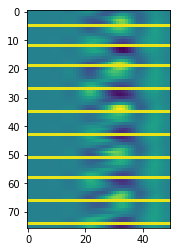

In [56]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
i = 16
img = X[i]
# img = cv2.resize(img, (76, 30))
img = zoom(img, (1, 5))
print(img.shape)
img[y[i] == 1, :] = 255
plt.imshow(img)
# plt.plot(y[1])
# X[0:8].shape

In [37]:
y[10].sum()

9